In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from math import sqrt

In [22]:
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [23]:
DATA_FILE = Path("indian_districts.csv")

if DATA_FILE.exists():
    df = pd.read_csv(DATA_FILE)
    print("Loaded real dataset:", DATA_FILE.resolve())
else:
    # Fallback synthetic dataset (keeps same columns)
    rng = np.random.default_rng(42)
    n = 2000
    population = rng.integers(50000, 3000000, size=n)
    growth_rate = rng.normal(1.2, 0.8, size=n)
    sex_ratio = rng.normal(950, 40, size=n)
    gr_abs = np.abs(growth_rate)
    literacy_rate = np.clip(55 + 0.00002*population + 2*np.log1p(gr_abs) + rng.normal(0,4,size=n), 30, 99)
    urban_pct = np.clip(rng.normal(30,20,size=n), 1, 100)
    df = pd.DataFrame({
        "population": population,
        "growth_rate": growth_rate,
        "sex_ratio": sex_ratio,
        "literacy_rate": literacy_rate,
        "urban_pct": urban_pct
    })
    print("No CSV found -> using synthetic fallback dataset")

print("Data shape:", df.shape)
display(df.head())


No CSV found -> using synthetic fallback dataset
Data shape: (2000, 5)


,population,growth_rate,sex_ratio,literacy_rate,urban_pct
0,313290,1.939486,1031.256007,62.092017,77.947532
1,2333170,1.227689,948.701027,99.000000,51.742204
2,1980985,0.973763,991.122143,95.267170,34.184050
3,1344691,1.115054,947.867885,77.737947,58.501587
4,1327394,1.378498,948.770247,87.237077,6.627302


Columns: ['population', 'growth_rate', 'sex_ratio', 'literacy_rate', 'urban_pct']

Missing values per column:
 population       0
growth_rate      0
sex_ratio        0
literacy_rate    0
urban_pct        0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
population,2000.0,1.524336e+06,856240.823006,53637.000000,776378.250000,1.527634e+06,2.273173e+06,2.997358e+06
growth_rate,2000.0,1.178527e+00,0.810442,-1.251024,0.644664,1.202441e+00,1.721274e+00,3.647625e+00
sex_ratio,2000.0,9.498592e+02,39.575147,824.253348,922.745497,9.492994e+02,9.750882e+02,1.088162e+03
literacy_rate,2000.0,8.430586e+01,14.108243,45.069801,72.229462,8.702750e+01,9.900000e+01,9.900000e+01
urban_pct,2000.0,3.050488e+01,18.504767,1.000000,17.284082,2.963052e+01,4.302860e+01,1.000000e+02


,population,growth_rate,sex_ratio,literacy_rate,urban_pct
population,1.000000,0.023547,0.031085,0.944865,0.010020
growth_rate,0.023547,1.000000,0.008401,0.053692,-0.007636
sex_ratio,0.031085,0.008401,1.000000,0.032773,-0.001588
literacy_rate,0.944865,0.053692,0.032773,1.000000,0.011963
urban_pct,0.010020,-0.007636,-0.001588,0.011963,1.000000


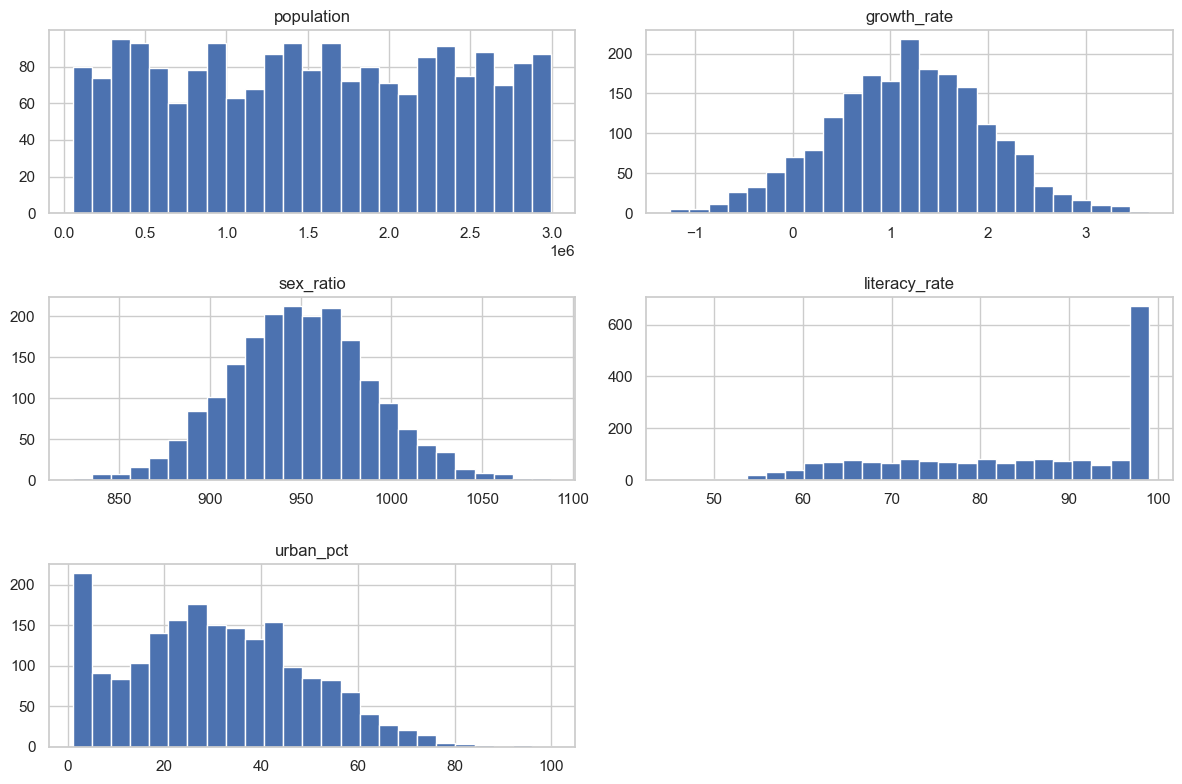

In [24]:
# Basic EDA: stats + correlations
print("Columns:", list(df.columns))
print("\nMissing values per column:\n", df.isna().sum())
display(df.describe().T)

# Use only numerical columns required by assignment
cols = ["population","growth_rate","sex_ratio","literacy_rate","urban_pct"]
display(df[cols].corr())

# Quick hist
df[cols].hist(bins=25, figsize=(12,8))
plt.tight_layout()
plt.show()


In [25]:
# Drop NA and reset
df = df.dropna().reset_index(drop=True)

FEATURES = ["population","growth_rate","sex_ratio","urban_pct"]
TARGET = "literacy_rate"

X = df[FEATURES].values.astype(float)
y = df[TARGET].values.astype(float)

# Deterministic split
rng = np.random.default_rng(RANDOM_SEED)
n = len(df)
perm = rng.permutation(n)
n_train = int(0.7 * n)
n_val = int(0.15 * n)
train_idx = perm[:n_train]
val_idx   = perm[n_train:n_train+n_val]
test_idx  = perm[n_train+n_val:]

X_train = X[train_idx]; y_train = y[train_idx]
X_val   = X[val_idx];   y_val   = y[val_idx]
X_test  = X[test_idx];  y_test  = y[test_idx]

def standardize_train(train, val=None, test=None):
    mu = train.mean(axis=0)
    sigma = train.std(axis=0)
    sigma[sigma == 0] = 1.0
    train_s = (train - mu) / sigma
    out = [train_s]
    if val is not None: out.append((val - mu) / sigma)
    if test is not None: out.append((test - mu) / sigma)
    return out if len(out) > 1 else out[0]

X_train_s, X_val_s, X_test_s = standardize_train(X_train, X_val, X_test)
print("Shapes (train,val,test):", X_train_s.shape, X_val_s.shape, X_test_s.shape)


Shapes (train,val,test): (1400, 4) (300, 4) (300, 4)


In [26]:
def mse(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    return np.mean((y_true - y_pred)**2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

def r2_score(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot != 0 else 0.0


In [27]:
class LinearRegressionGD:
    def __init__(self, lr=0.01, epochs=200, method="batch", batch_size=32, verbose=False):
        assert method in ("batch","sgd")
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.method = method
        self.batch_size = int(batch_size)
        self.verbose = verbose
        self.w = None
        self.b = 0.0
        self.loss_history = []  # list of (train_mse, val_mse or None)

    def fit(self, X, y, X_val=None, y_val=None):
        n, d = X.shape
        self.w = np.zeros(d, dtype=float)
        self.b = 0.0
        self.loss_history = []
        for epoch in range(self.epochs):
            if self.method == "batch":
                pred = X.dot(self.w) + self.b
                err = pred - y
                grad_w = (2.0/n) * X.T.dot(err)
                grad_b = (2.0/n) * np.sum(err)
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b
            else:
                idx = np.arange(n)
                np.random.shuffle(idx)
                for start in range(0, n, self.batch_size):
                    batch_idx = idx[start:start+self.batch_size]
                    if len(batch_idx) == 0:
                        continue
                    Xb = X[batch_idx]; yb = y[batch_idx]
                    predb = Xb.dot(self.w) + self.b
                    errb = predb - yb
                    grad_wb = (2.0/len(batch_idx)) * Xb.T.dot(errb)
                    grad_bb = (2.0/len(batch_idx)) * np.sum(errb)
                    self.w -= self.lr * grad_wb
                    self.b -= self.lr * grad_bb
            # record losses
            train_pred = X.dot(self.w) + self.b
            train_mse = mse(y, train_pred)
            val_mse = None
            if X_val is not None and y_val is not None:
                val_pred = X_val.dot(self.w) + self.b
                val_mse = mse(y_val, val_pred)
            self.loss_history.append((train_mse, val_mse))
            if self.verbose and (epoch % max(1, self.epochs//10) == 0):
                print(f"Epoch {epoch+1}/{self.epochs} train_mse={train_mse:.6f} val_mse={val_mse}")
        return self

    def predict(self, X):
        return X.dot(self.w) + self.b


In [28]:
learning_rates = [1e-4, 1e-3, 1e-2]   # as required
methods = ["batch","sgd"]
epochs = 300
batch_size = 32

results = {}  # key: (method, lr) -> dict with model, metrics, preds

for method in methods:
    for lr in learning_rates:
        print(f"Training {method} GD, lr={lr}")
        model = LinearRegressionGD(lr=lr, epochs=epochs, method=method, batch_size=batch_size, verbose=False)
        model.fit(X_train_s, y_train, X_val=X_val_s, y_val=y_val)
        y_val_pred = model.predict(X_val_s)
        y_test_pred = model.predict(X_test_s)
        results[(method, lr)] = {
            "model": model,
            "val_metrics": {"mse": mse(y_val, y_val_pred), "rmse": rmse(y_val, y_val_pred), "mae": mae(y_val, y_val_pred), "r2": r2_score(y_val, y_val_pred)},
            "test_metrics": {"mse": mse(y_test, y_test_pred), "rmse": rmse(y_test, y_test_pred), "mae": mae(y_test, y_test_pred), "r2": r2_score(y_test, y_test_pred)},
            "y_val_pred": y_val_pred,
            "y_test_pred": y_test_pred
        }

# summary table
rows = []
for (method, lr), info in results.items():
    rows.append({
        "method": method, "lr": lr,
        "val_mse": info["val_metrics"]["mse"],
        "val_rmse": info["val_metrics"]["rmse"],
        "val_mae": info["val_metrics"]["mae"],
        "val_r2": info["val_metrics"]["r2"],
        "test_mse": info["test_metrics"]["mse"],
        "test_rmse": info["test_metrics"]["rmse"],
        "test_mae": info["test_metrics"]["mae"],
        "test_r2": info["test_metrics"]["r2"],
    })
report_df = pd.DataFrame(rows).sort_values(["method","lr"])
display(report_df)


Training batch GD, lr=0.0001
Training batch GD, lr=0.001
Training batch GD, lr=0.01
Training sgd GD, lr=0.0001
Training sgd GD, lr=0.001
Training sgd GD, lr=0.01


,method,lr,val_mse,val_rmse,val_mae,val_r2,test_mse,test_rmse,test_mae,test_r2
0,batch,0.0001,6465.531692,80.408530,79.212860,-29.436790,6226.786277,78.909988,77.729760,-29.311233
1,batch,0.0010,2210.425902,47.015167,46.164020,-9.405682,2130.785094,46.160428,45.308256,-9.372401
2,batch,0.0100,22.159761,4.707416,3.880548,0.895682,20.787323,4.559312,3.726571,0.898810
3,sgd,0.0001,59.760186,7.730471,6.468066,0.718676,57.833812,7.604854,6.424017,0.718472
4,sgd,0.0010,22.094419,4.700470,3.876431,0.895989,20.693728,4.549036,3.718735,0.899265
5,sgd,0.0100,22.093817,4.700406,3.875704,0.895992,20.737194,4.553811,3.723312,0.899054


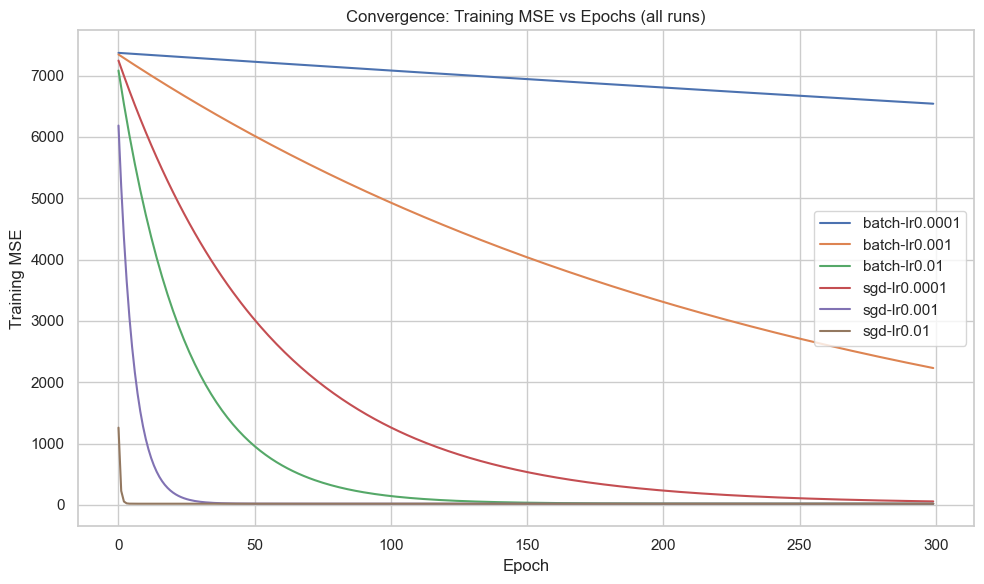

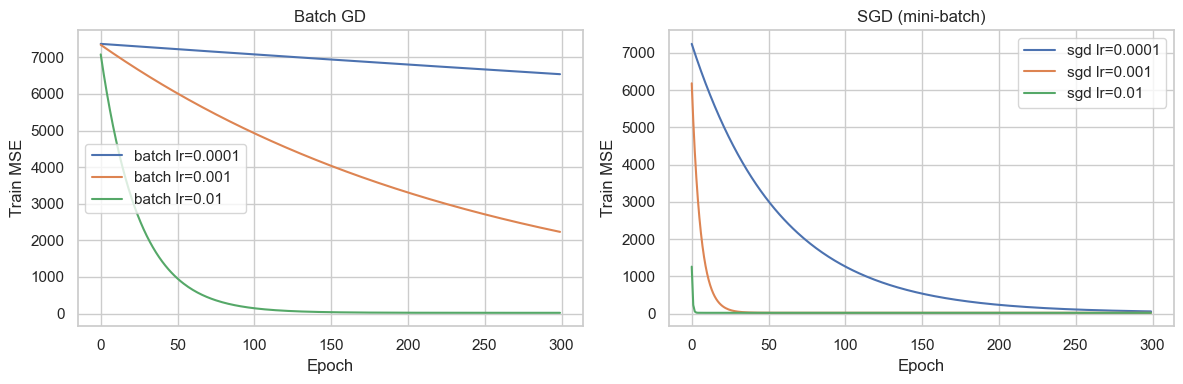

In [29]:
# Plot training loss curves for all (method,lr) combos
plt.figure(figsize=(10,6))
for key, info in results.items():
    method, lr = key
    train_losses = np.array([t for t,_ in info["model"].loss_history])
    plt.plot(train_losses, label=f"{method}-lr{lr}")
plt.xlabel("Epoch")
plt.ylabel("Training MSE")
plt.title("Convergence: Training MSE vs Epochs (all runs)")
plt.legend()
plt.tight_layout()
plt.show()

# Also separate: Batch vs SGD panels for clarity
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for lr in learning_rates:
    arr = np.array(results[("batch", lr)]["model"].loss_history)[:,0]
    plt.plot(arr, label=f"batch lr={lr}")
plt.title("Batch GD")
plt.xlabel("Epoch"); plt.ylabel("Train MSE"); plt.legend()

plt.subplot(1,2,2)
for lr in learning_rates:
    arr = np.array(results[("sgd", lr)]["model"].loss_history)[:,0]
    plt.plot(arr, label=f"sgd lr={lr}")
plt.title("SGD (mini-batch)")
plt.xlabel("Epoch"); plt.ylabel("Train MSE"); plt.legend()

plt.tight_layout()
plt.show()


In [30]:
OUT = Path("./outputs")
OUT.mkdir(exist_ok=True)

for method in methods:
    for lr in learning_rates:
        key = (method, lr)
        y_test_pred = results[key]["y_test_pred"]
        # Pred vs actual
        plt.figure(figsize=(6,5))
        plt.scatter(y_test, y_test_pred, alpha=0.5)
        mn = min(y_test.min(), y_test_pred.min()); mx = max(y_test.max(), y_test_pred.max())
        plt.plot([mn,mx],[mn,mx], linestyle="--")
        plt.xlabel("Actual literacy_rate"); plt.ylabel("Predicted literacy_rate")
        plt.title(f"Predicted vs Actual ({method}, lr={lr})")
        fname1 = OUT / f"pred_vs_actual_{method}_lr{lr}.png"
        plt.tight_layout(); plt.savefig(fname1); plt.close()

        # Residuals
        residuals = y_test - y_test_pred
        plt.figure(figsize=(6,4))
        plt.scatter(y_test_pred, residuals, alpha=0.5)
        plt.axhline(0, linestyle="--")
        plt.xlabel("Predicted"); plt.ylabel("Residual (Actual - Pred)")
        plt.title(f"Residuals ({method}, lr={lr})")
        fname2 = OUT / f"residuals_{method}_lr{lr}.png"
        plt.tight_layout(); plt.savefig(fname2); plt.close()

print("Saved predicted/residual plots to", OUT.resolve())


Saved predicted/residual plots to C:\Users\Gauta\outputs


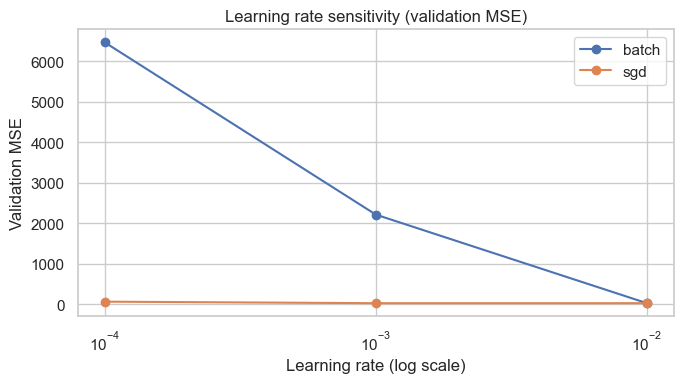

In [31]:
plt.figure(figsize=(7,4))
for method in methods:
    lrs = []
    val_mses = []
    for lr in learning_rates:
        lrs.append(lr)
        val_mses.append(results[(method, lr)]["val_metrics"]["mse"])
    plt.plot(lrs, val_mses, marker='o', label=method)
plt.xscale("log")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Validation MSE")
plt.title("Learning rate sensitivity (validation MSE)")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
class KNNClassifier:
    def __init__(self, k=3):
        assert k >= 1
        self.k = int(k)
        self.X = None
        self.y = None

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def _distances(self, Xq):
        Xq = np.array(Xq)
        # compute Euclidean distances (m x n)
        dists = np.sqrt(((Xq[:, None, :] - self.X[None, :, :])**2).sum(axis=2))
        return dists

    def predict(self, Xq):
        dists = self._distances(Xq)
        nn_idx = np.argsort(dists, axis=1)[:, :self.k]
        preds = []
        for inds in nn_idx:
            labels = self.y[inds]
            vals, counts = np.unique(labels, return_counts=True)
            preds.append(vals[np.argmax(counts)])
        return np.array(preds)


In [33]:
def literacy_label(x):
    if x < 65: return "Low"
    if x <= 85: return "Medium"
    return "High"

train_labels = np.array([literacy_label(v) for v in y_train])
val_labels   = np.array([literacy_label(v) for v in y_val])
test_labels  = np.array([literacy_label(v) for v in y_test])

ks = [3,5,7]
knn_results = {}
for k in ks:
    knn = KNNClassifier(k=k)
    knn.fit(X_train_s, train_labels)
    test_pred = knn.predict(X_test_s)
    acc = np.mean(test_pred == test_labels)
    cm = pd.crosstab(pd.Series(test_labels, name="true"), pd.Series(test_pred, name="pred"), dropna=False)
    knn_results[k] = {"accuracy": acc, "confusion": cm, "test_pred": test_pred}
    print(f"k={k}  Test accuracy: {acc:.4f}")


k=3  Test accuracy: 0.7900
k=5  Test accuracy: 0.7867
k=7  Test accuracy: 0.7967


In [34]:
# Save class distribution
pd.Series(train_labels).value_counts().reindex(["Low","Medium","High"], fill_value=0).plot(kind="bar")
plt.title("Class distribution (train)")
plt.xlabel("Literacy class"); plt.ylabel("Count")
plt.tight_layout()
plt.savefig(OUT / "class_distribution_train.png")
plt.close()

# Save confusion matrices for each k
for k in ks:
    cm = knn_results[k]["confusion"].reindex(index=["Low","Medium","High"], columns=["Low","Medium","High"], fill_value=0)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=True)
    plt.title(f"Confusion matrix (k={k})")
    plt.tight_layout()
    plt.savefig(OUT / f"confusion_k{k}.png")
    plt.close()

print("Saved KNN plots to", OUT.resolve())


Saved KNN plots to C:\Users\Gauta\outputs


In [35]:
def k_fold_cv_knn(X, y, k_neighbors=5, folds=5, seed=1):
    n = len(X)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    fold_sizes = [n//folds + (1 if i < n%folds else 0) for i in range(folds)]
    starts = np.cumsum([0] + fold_sizes[:-1])
    accs = []
    for i in range(folds):
        val_idx = idx[starts[i]:starts[i]+fold_sizes[i]]
        train_idx = np.setdiff1d(idx, val_idx)
        knn = KNNClassifier(k=k_neighbors)
        knn.fit(X[train_idx], y[train_idx])
        pred = knn.predict(X[val_idx])
        accs.append(np.mean(pred == y[val_idx]))
    return np.mean(accs), np.std(accs)

combined_X = np.vstack([X_train_s, X_val_s])
combined_y = np.concatenate([train_labels, val_labels])

cv_summary = {}
for k in ks:
    mean_acc, std_acc = k_fold_cv_knn(combined_X, combined_y, k_neighbors=k, folds=5)
    cv_summary[k] = (mean_acc, std_acc)
    print(f"k={k}: CV mean acc = {mean_acc:.4f}, std = {std_acc:.4f}")


k=3: CV mean acc = 0.8441, std = 0.0243
k=5: CV mean acc = 0.8418, std = 0.0265
k=7: CV mean acc = 0.8435, std = 0.0175


In [36]:
# Save LR metrics
lr_rows = []
for (method, lr), info in results.items():
    lr_rows.append({
        "method": method, "lr": lr,
        "val_mse": info["val_metrics"]["mse"], "val_rmse": info["val_metrics"]["rmse"],
        "val_mae": info["val_metrics"]["mae"], "val_r2": info["val_metrics"]["r2"],
        "test_mse": info["test_metrics"]["mse"], "test_rmse": info["test_metrics"]["rmse"],
        "test_mae": info["test_metrics"]["mae"], "test_r2": info["test_metrics"]["r2"]
    })
pd.DataFrame(lr_rows).to_csv(OUT / "lr_metrics_report.csv", index=False)

# Save KNN CV summary and accuracies
with open(OUT / "knn_summary.txt", "w") as f:
    f.write("KNN summary (test accuracies + CV on train+val)\n")
    for k in ks:
        f.write(f"k={k}: test_acc={knn_results[k]['accuracy']:.4f}, cv_mean={cv_summary[k][0]:.4f}, cv_std={cv_summary[k][1]:.4f}\n")

# Short text report
best_lr_key = max(results.keys(), key=lambda k: results[k]["val_metrics"]["r2"])
with open(OUT / "short_report.txt", "w") as f:
    f.write("Assignment 1 — short report summary\n")
    f.write(f"Dataset source: {'real' if DATA_FILE.exists() else 'synthetic (fallback)'}\n")
    f.write(f"Best LR model by val R2: {best_lr_key}\n")
    f.write("\nKNN CV summary:\n")
    for k,(m,s) in cv_summary.items():
        f.write(f"  k={k}: mean acc={m:.4f}, std={s:.4f}\n")
    f.write("\nSaved files in ./outputs\n")

print("Saved CSV and text summaries to", OUT.resolve())


Saved CSV and text summaries to C:\Users\Gauta\outputs
